In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
# Download stock data
stock_symbol = 'MSFT'
start_date = '2010-01-01'
end_date = '2023-04-12'
data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:

# Preprocess data
data = data['Close'].values
data = data.reshape(-1, 1)

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Train-test split
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [6]:
# Create sequences
def create_sequences(data, seq_length):
    inputs = []
    targets = []

    for i in range(len(data) - seq_length):
        inputs.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])

    return np.array(inputs), np.array(targets)

seq_length = 20
train_inputs, train_targets = create_sequences(train_data, seq_length)
test_inputs, test_targets = create_sequences(test_data, seq_length)

# Convert data to tensors
train_inputs = torch.tensor(train_inputs).float()
train_targets = torch.tensor(train_targets).float()
test_inputs = torch.tensor(test_inputs).float()
test_targets = torch.tensor(test_targets).float()


In [7]:

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [8]:


# Instantiate the model
input_dim = 1
hidden_dim = 64
num_layers = 1
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [9]:
# Train the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_inputs)
    loss = loss_fn(outputs, train_targets)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

# Test the model
model.eval()
predicted = model(test_inputs)

# Inverse transform
predicted = scaler.inverse_transform(predicted.detach().numpy())
test_targets = scaler.inverse_transform


Epoch [10/50], Loss: 0.316360
Epoch [20/50], Loss: 0.038551
Epoch [30/50], Loss: 0.040875
Epoch [40/50], Loss: 0.037718
Epoch [50/50], Loss: 0.032498


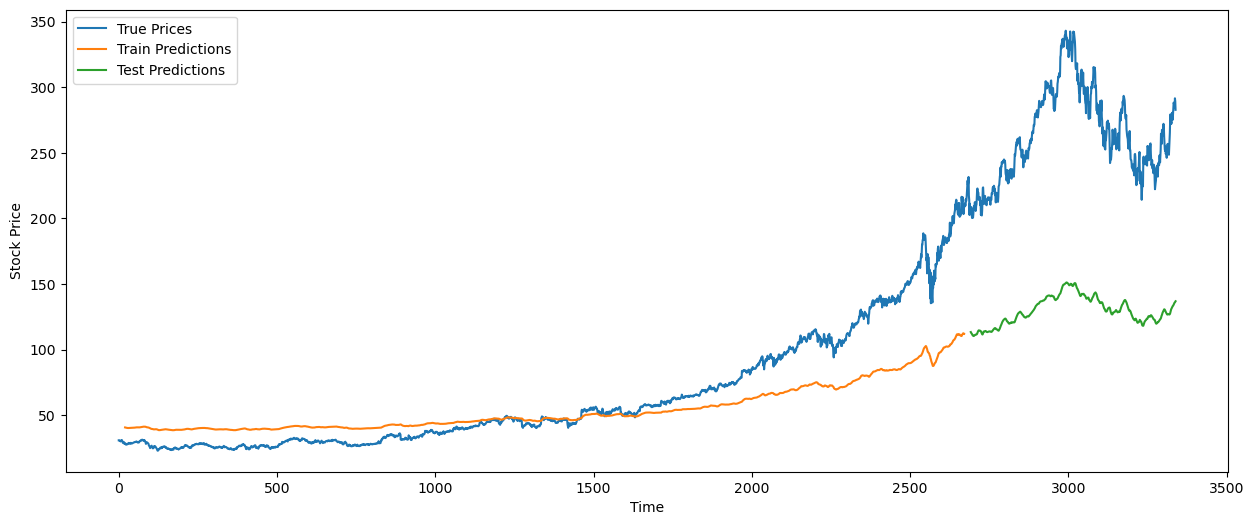

In [10]:
# Visualize the predictions for the train dataset
train_predict = model(train_inputs)
train_predict = scaler.inverse_transform(train_predict.detach().numpy())
train_data_plot = np.empty_like(data)
train_data_plot[:, :] = np.nan
train_data_plot[seq_length:len(train_predict) + seq_length, :] = train_predict

# Visualize the predictions for the test dataset
test_predict = model(test_inputs)
test_predict = scaler.inverse_transform(test_predict.detach().numpy())
test_data_plot = np.empty_like(data)
test_data_plot[:, :] = np.nan
test_data_plot[len(train_predict) + (seq_length * 2):, :] = test_predict

# Plot the stock prices
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='True Prices')
plt.plot(train_data_plot, label='Train Predictions')
plt.plot(test_data_plot, label='Test Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
